# Assignment 2 - 3EBX0 - Machine Learning in Science
Group: Tutti Frutti

Authors: Filippo Tirelli 1630253, Mikołaj Kahl 1553593, Bruno Gawęcki 1572342 


This document covers Assignment II of the course Machine Learning in Science 3EBX0. It includes an introduction, where the assignment is explained and the problem is defined rigorously. A second chapter focuses on Problem Analysis. Here, many aspects are discussed. Text sections and code cells alternate in this section, in order to illustrate the entire thinking process behind this assignment. The document ends with the Conclusion chapter where final considerations and comments are made. 

## Introduction

Consider a string of $N$ fence panels interconnected to eachother. Each panel has a length $l_1, l_2, ..., l_n$. Joining the last side with the first one results into an enclosed area. The goal of the assignment is to build a neural network which computes the maximum value of the enclosed area, given a set of arrays containing side lengths. 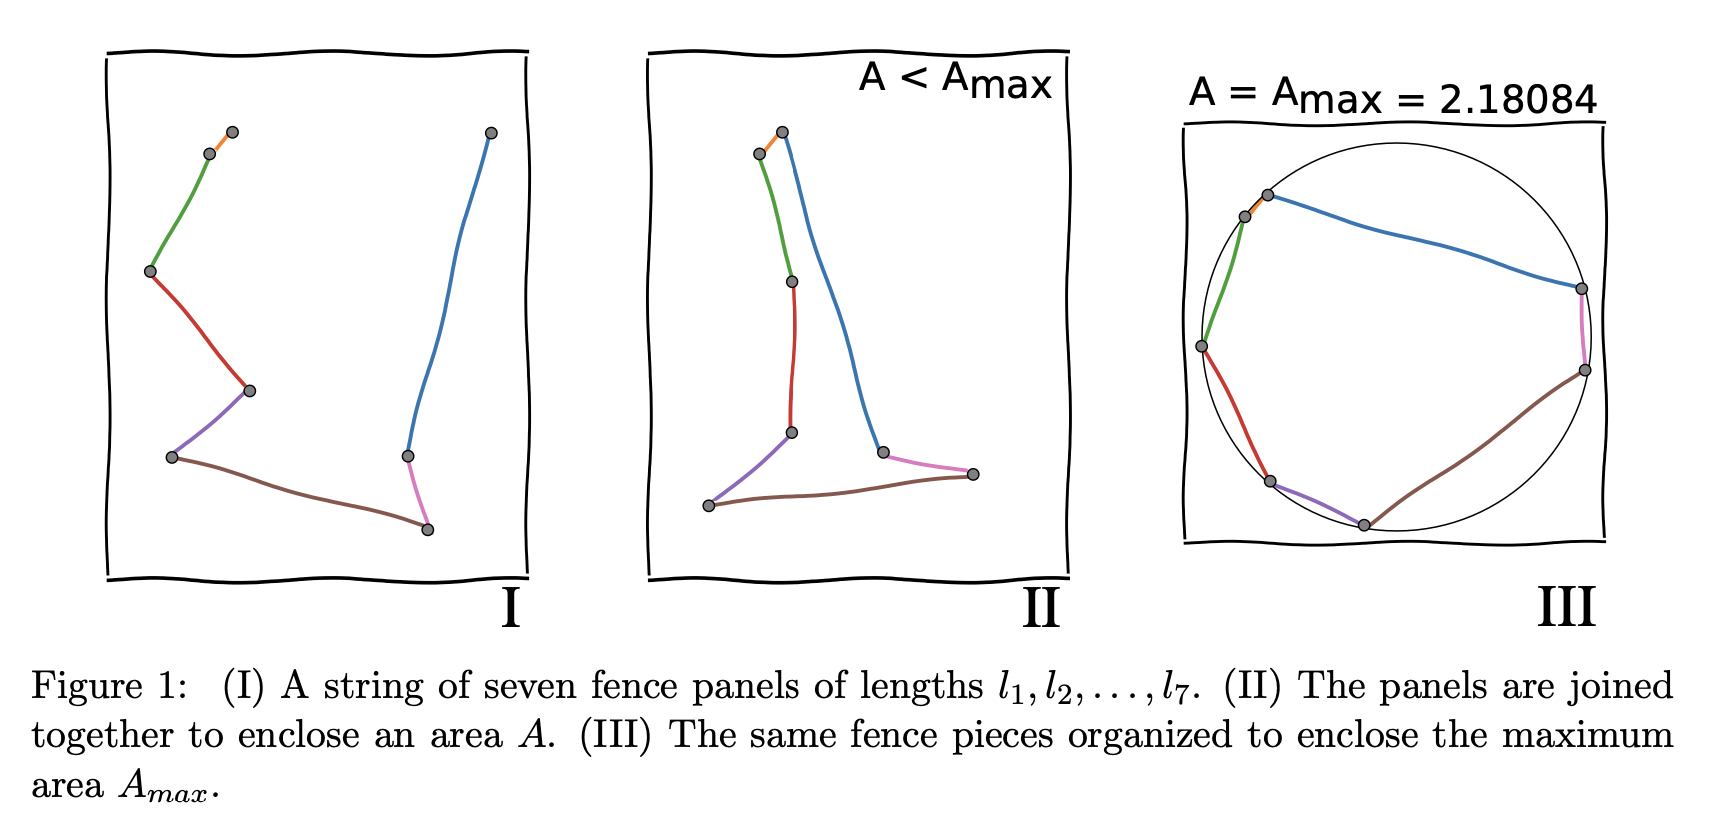 

It can be shown that for a given set of lengths, the maximum enclosed area is obtained when all the sides of the fence laying in a circle, and all corners being on the rircle. These shapes are called cyclic poligons. The problem focuses merely on the numerical outcome rather than on the geometrical aspect, therefore the goal of this assignment is to find the maximum enclosed area, regardless of the geometrical configuration of the sides. 

The given problem cosnider the cases where $N=7$ and the groups is provided a data set including $10 000$ training samples ($l_1, l_2,...,l_7$). 

# Problem analysis 
This section focuses on all the aspects that must be considered to get from the description of the assignment to the final result. It will include text explanations and the related code cells.  

To begin, all the needed libraries are imported, including `tensorflow`, `numpy`, `pandas`, `sklearn` and `matplotlib`. Without these, none of the code cells that will follow can be executed. 

In [ ]:
%tensorflow_version 2.x 
%load_ext tensorboard   
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Once all the libraries have been imported, the provided data can be loaded. Using the `train_test_split` funciton of the `sklearn` library, the data is split into training and test data sets, with a $80\%$ as training data and $20\%$ as test data. The data is also formated to our liking.

In [ ]:
data_X = pd.read_csv('x_train_id.csv')
data_X.drop('id', axis=1, inplace=True)
data_y = pd.read_csv('y_train_id.csv')
data_y.drop('id', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, train_size=0.8, shuffle=False)

X_train = X_train.reset_index().drop(columns=['index'])
X_test = X_test.reset_index().drop(columns=['index'])
y_train = y_train.reset_index().drop(columns=['index'])
y_test = y_test.reset_index().drop(columns=['index'])
X_test

,0,1,2,3,4,5,6
0,0.392905,0.812277,1.439354,1.820535,0.269753,0.024970,0.834811
1,0.485280,0.670494,0.588009,0.644473,0.189398,1.467573,1.693041
2,0.923132,0.822020,1.467832,0.579880,0.249886,0.394314,1.429562
3,0.217913,0.846015,1.432910,0.090219,1.016254,0.784738,1.456288
4,1.245294,0.719441,0.465555,0.555845,0.333538,1.587778,0.959219
...,...,...,...,...,...,...,...
1995,1.410615,0.449163,0.056344,0.134550,1.463127,1.531113,0.674892
1996,0.845836,0.413648,0.416795,1.135140,0.621629,0.033441,1.951597
1997,0.345894,0.618574,1.858856,0.077312,0.697965,0.416950,1.509540
1998,0.977739,0.154170,0.186002,0.988009,0.688240,0.140251,1.997651


# Ensuring Dimensional homgeneity


## Network 1. Naive network implementation - 7 inputs
An essential aspect to consider in such a problem is Dimensional Homogeneity. In other words, the inputs and the output of the problem must have the same unit. Here, the output is the maximum enclosed area, which has unit $m^2$. The inputs represent the sides of a fence, which have unit $m$. This means that there is no dimensionally homogeneity between inputs and output. To conserve dimensional homegeneity, such combinations of the lengths of fence sides are used, so that the resulting expressions are in the unit $m^2$. This is done for all model inputs that are used in this assignment.

An essential aspect to consider in such a problem is Dimensional Homogeneity. In other words, the inputs and the output of the problem must have the same unit. Here, the output is the maximum enclosed area, which has unit $m^2$. The inputs represent the sides of a fence, which have unit $m$. This means that there is not dimensionally homogeneity between inputs and output. To conserve dimensional homegeneity, squars of the lengths are computed, which have the unit of $m^2$.

In [ ]:
X_train_squared = X_train.pow(2)
X_test_squared = X_test.pow(2)

In the entire asignment, a number of functions presented in class, by the teaching team, will be used. These will be used to efficeintly create, train and analyze the neural networks we built. The functions have been altered slightly, so that they better fit this specific assigment's needs.

The cell below defines a function which builds a neural notwork with 7 inputs, and 2 dense layers with 28 neurons each, followed by 1 dense layer with one output at the end. Rectified linear units are used as activation functions in between layers. The graphical representation of the network can be seen below.

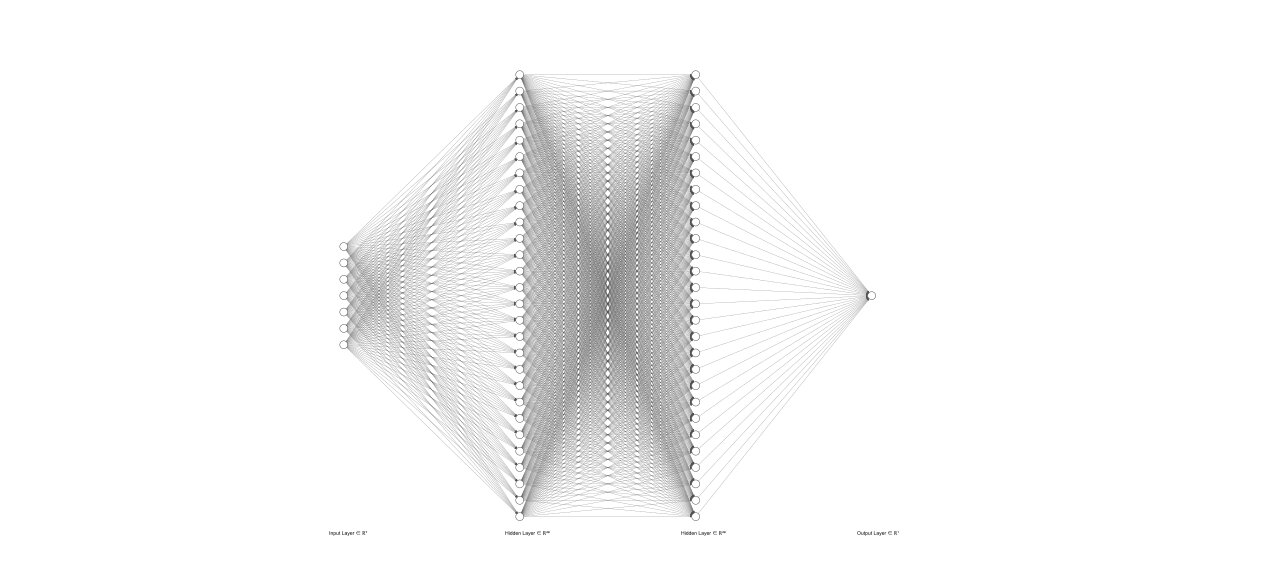

In [ ]:
def create_model(loss="mape", optimizer="adam", input_size=7, per_layer=28):
    model = Sequential()
    model.add(Dense(per_layer, input_shape=(input_size,), activation="relu", use_bias=False, kernel_initializer = "he_uniform"))
    model.add(Dense(per_layer, activation="relu", use_bias=False, kernel_initializer = "he_uniform"))
    model.add(Dense(per_layer, activation="relu", use_bias=False, kernel_initializer = "he_uniform"))
    model.add(Dense(1 , activation="linear", use_bias=False))
    model.compile(loss=loss, optimizer=optimizer)
    
    return(model)

The function `train` defined below trains `ntrials` neural networks and stores each of the models in a returned list.

In [ ]:
def train(X_train, y_train, X_test, y_test, ntrials=5, n_epochs=150, patience=25, batch_size=32, name=''):
    """Train neural network and save models in history."""
    model_lst = []
    for k in range(ntrials):
        model = create_model()
        
        es_callback = [EarlyStopping(monitor = "val_loss", patience=patience, restore_best_weights=True)]

        ## Introduce tensorboard
        ## save into "logs/model_YYYYMMDD-HHMMSS" (you can obviously change this)
        my_dir = 'model_' + str(name)
        logdir = os.path.join("logs", my_dir)
        tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  
        keras_callbacks = [tb_callback, es_callback]

        hist = model.fit(X_train, y_train, 
                         epochs=n_epochs, verbose=0, callbacks=keras_callbacks, batch_size=batch_size,
                         validation_data=(X_test, y_test))
        model_lst.append({'model':model, 'hist':hist})
    
    return model_lst

The function `evaluate_net` evaluates the MAPE of each model and plots a graph of the loss function, comparing the training and test data.

In [ ]:
def evaluate_net(model_lst, X_test, y_test, w=8, h=5):
    ntrials = len(model_lst)

    for k in range(ntrials):
        model = model_lst[k].get('model')
        err = model.evaluate(X_test, y_test)
        print(f"Model {k}: Error = {err} %")    
        plt.figure( figsize=(w,h))
        hist = model_lst[k].get('hist')
        plt.semilogy(hist.history["loss"], label="Training")
        plt.semilogy(hist.history["val_loss"], label="Validation")
        plt.title(f'Training vs Validation Loss for Model {k}')
        plt.legend()
        plt.show()    

The network that performed best out of the `ntrials` is retrieved by the `get_best_network` function defined below. This netork will be used to make predictions on the validation data.

In [ ]:
def get_best_network(model_lst, X_test, y_test):
    ntrials = len(model_lst)
    best_err = 1e10
    idx_best = None
    for k in range(ntrials):
        model = model_lst[k].get('model')
        err = model.evaluate(X_test, y_test)
        if err < best_err:
            best_err = err
            idx_best = k

    return idx_best

In [ ]:
naive_models = train(X_train_squared, y_train, X_test_squared, y_test, name='naive')
evaluate_net(naive_models, X_test_squared, y_test)
best_naive_network = get_best_network(naive_models, X_test_squared, y_test)
best_naive_network

Running the naive network resulted in the following loss:

63/63 [==============================] - 0s 2ms/step - loss: 3.3691

As expected, the naive neural network did not perform well, that is why other alternative approaches have been used, where the data is pocessed before letting the model train on the data.

# Network 2. Disambiguation of Data by Sorting - 7 inputs
One of the initial ideas to disambiguate the data set is for each row in the dataset, arrange the lengths in descending order. For that purpose, `sort_ascending` function has been written below:

In [ ]:
def sort_ascending(data):
    sorted_array = np.empty_like(data)
    for index, row in enumerate(data):
        row.sort()
        sorted_array[index] = row
    df = pd.DataFrame(sorted_array) 
    return df

In [ ]:
X_train_sorted = sort_ascending(X_train_squared.to_numpy())
X_test_sorted = sort_ascending(X_test_squared.to_numpy())

In [ ]:
sorted_models = train(X_train_sorted, y_train, X_test_sorted, y_test, name='sorted')
evaluate_net(sorted_models, X_test_sorted, y_test)
best_sorted_network = get_best_network(sorted_models, X_test_sorted, y_test)
best_naive_network

Sorting the data showed a great improvement in the loss:

63/63 [==============================] - 0s 2ms/step - loss: 0.9861

This approach seems to improve the network's performance significantly, but there is no real underlying physical explanation on why it actually works (At least the group did not manage to explain it at this point). Therefore, an alternative aproach was used.

# Network 3. Disambiguation by Using Symmetry - 7 inputs
 A very similar apporach for disambiguating the data has been used, as was presented in class for the heptagon exercise. The model takes advantage of the equivariance groups present in the problem. Both rotational symmetry and mirroring are used for this purpose. This is because it does not matter in what orientation in space the polygon is. As long as the angles and the order between the neighbouring sides are unchanged, the area is also unchanged, ensuring invariance of the maximum enclosed area.


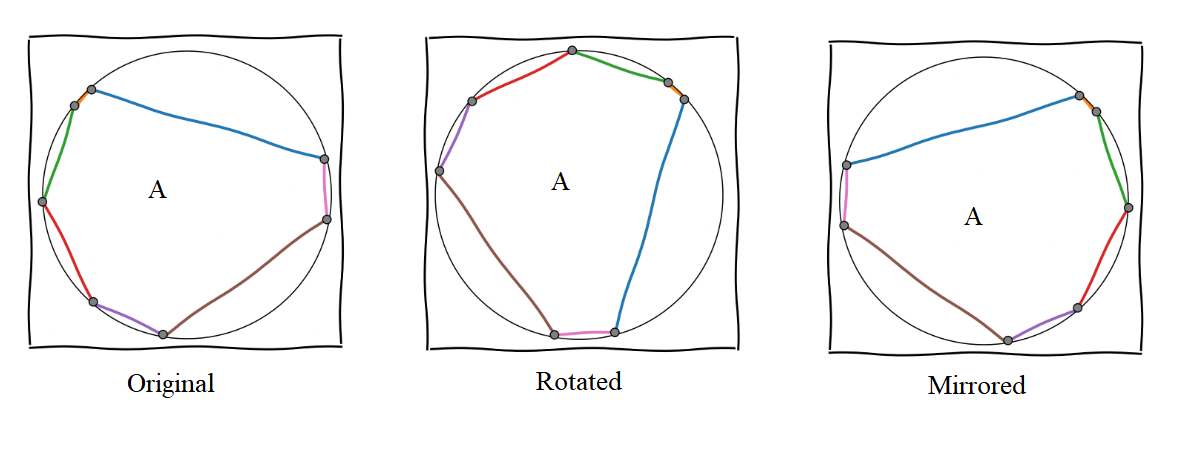

In order to disambiguate the data, we used the functions that were already defined by Prof. Alessandro Gabbana in Lab7 notebook.


In [ ]:
def cyclic_sorting(qA):
    """receives datapoints and rearranges such that the maximum value is in the first position"""
    N_rows = qA.shape[0] 
    qA_sorted = np.zeros_like(qA)
        
    for idx in range(N_rows):
        idx_of_max = np.argmax(qA[idx,:])
        qA_sorted[idx,:] = np.roll(qA[idx,:], shift=-idx_of_max)
    return qA_sorted

def mirror_cyclic(qA):
    """Expects rolled data, disambiguates mirror symmetry"""
    N_cases = qA.shape[0]
    qA_sorted = qA.copy()
    
    for idx in range(N_cases):
        if qA_sorted[idx,1] < qA_sorted[idx,-1]:
            qA_sorted[idx,1:] = np.flip(qA_sorted[idx,1:])
    return qA_sorted


The shifting is first done via `cyclic_sorting`, so that the first array element in the data set is the side of the largest length. Mirroring is then applied, using `mirror_cyclic` so that the neighbour at index $1$ is the biggest of the two neighbours.

In [ ]:
X_train_cycle = mirror_cyclic(cyclic_sorting(X_train.to_numpy()))
X_test_cycle = mirror_cyclic(cyclic_sorting(X_test.to_numpy()))
df_train = pd.DataFrame(X_train_cycle)
df_test = pd.DataFrame(X_test_cycle)
df_test

,0,1,2,3,4,5,6
0,1.820535,1.439354,0.812277,0.392905,0.834811,0.024970,0.269753
1,1.693041,1.467573,0.189398,0.644473,0.588009,0.670494,0.485280
2,1.467832,0.822020,0.923132,1.429562,0.394314,0.249886,0.579880
3,1.456288,0.784738,1.016254,0.090219,1.432910,0.846015,0.217913
4,1.587778,0.959219,1.245294,0.719441,0.465555,0.555845,0.333538
...,...,...,...,...,...,...,...
1995,1.531113,1.463127,0.134550,0.056344,0.449163,1.410615,0.674892
1996,1.951597,0.845836,0.413648,0.416795,1.135140,0.621629,0.033441
1997,1.858856,0.618574,0.345894,1.509540,0.416950,0.697965,0.077312
1998,1.997651,0.977739,0.154170,0.186002,0.988009,0.688240,0.140251


Surprisingly, this apporach did not work as expected, therefore no evaluation of this network is presented in the notebook. After testing the above data as inputs, another approach has been developed. 

# Network 4. Disambiguation Using Symmetry - 14 inputs

For the third try, the number of inputs has been increased, so that there are additional inputs that reassemble the angles. It has been chosen that the lengths of two consecutive sides of the heptagon will be multiplied, so that the result somehow represents the dot product between the two sides.

In [ ]:
def add_columns(df):
    for col in range(1,7):
        df[f"{col-1}{col}"] = df[col-1]*df[col]
        df[f'{col-1}^2'] = df[col-1]*df[col-1]
    df['60'] = df[0]*df[6]
    df['6^2'] = df[6]*df[6]
    return df

Many data sets were treated already in this notebook, therefore, in the cell below the data set for the next task is defined. The variables `X_train_dis` and `X_test_dis` are assigned to it.



In [ ]:
input_cols = ['0^2', '01', '1^2', '12', '2^2', '23', '3^2', '34', '4^2', '45', '5^2', '56', '6^2', '60']
X_train_dis, X_test_dis = add_columns(df_train)[input_cols], add_columns(df_test)[input_cols]
input_length = X_train_dis.shape[1]
X_train_dis

,0^2,01,1^2,12,2^2,23,3^2,34,4^2,45,5^2,56,6^2,60
0,2.124915,2.100313,2.075996,0.091963,0.004074,0.052496,0.676478,0.522836,0.404090,0.620890,0.954006,0.447518,0.209928,0.667891
1,3.326650,0.851141,0.217769,0.808333,3.000438,0.603049,0.121205,0.167652,0.231897,0.219525,0.207813,0.057090,0.015684,0.228418
2,3.270296,0.862594,0.227523,0.780551,2.677793,0.505143,0.095291,0.037043,0.014400,0.107967,0.809502,0.235758,0.068662,0.473861
3,2.393757,2.127294,1.890492,0.187577,0.018612,0.196206,2.068434,0.180869,0.015816,0.100758,0.641912,0.244583,0.093191,0.472311
4,3.859194,1.158423,0.347727,0.600676,1.037630,1.454222,2.038070,0.071940,0.002539,0.004472,0.007874,0.010882,0.015038,0.240900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,2.832100,1.960074,1.356552,1.378475,1.400752,0.045099,0.001452,0.013718,0.129609,0.299345,0.691369,0.424251,0.260337,0.858663
7996,3.999574,2.836821,2.012102,0.242370,0.029195,0.024740,0.020965,0.055609,0.147500,0.201365,0.274901,0.183827,0.122925,0.701177
7997,3.304319,2.781622,2.341608,1.808593,1.396907,0.090036,0.005803,0.031677,0.172908,0.028779,0.004790,0.029581,0.182684,0.776946
7998,2.969929,2.285094,1.758175,0.082527,0.003874,0.051481,0.684172,0.332319,0.161415,0.260035,0.418908,0.490861,0.575174,1.306991


Once the data has been disambiguated, it is possible to start developing the model. The new neural network is very similar to the one used for the models above, but now the input size changed from 7 to 14.

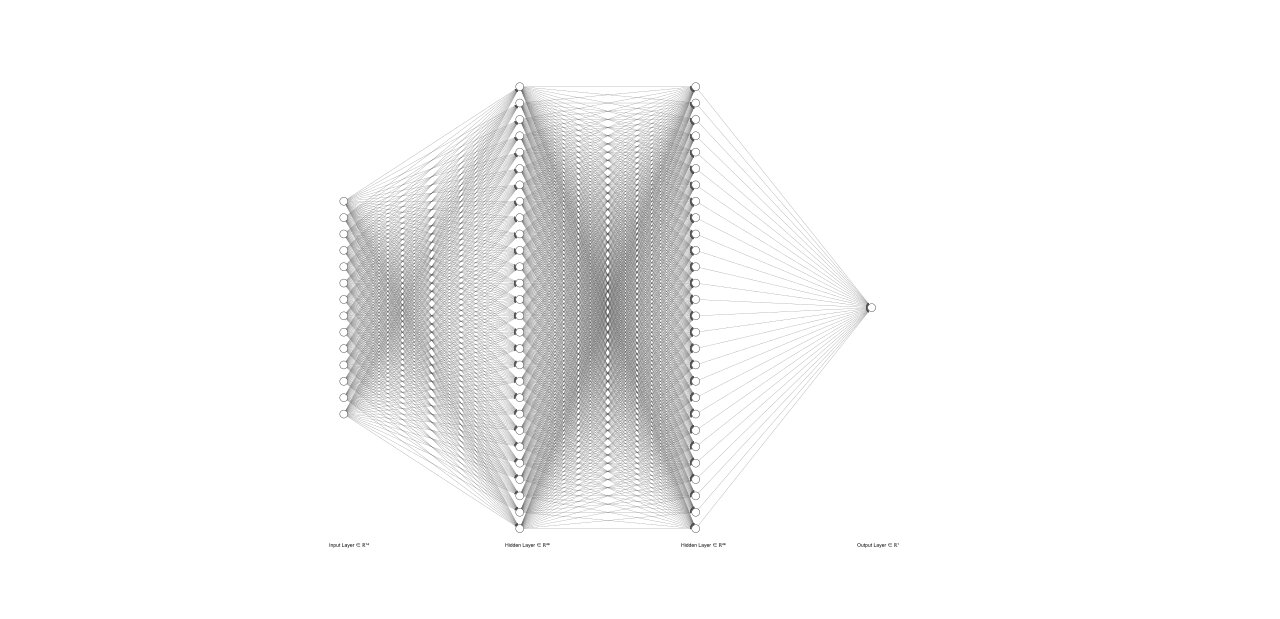

In [ ]:
def create_model(loss="mape", optimizer="adam", input_size=14, per_layer=28):
    model = Sequential()
    model.add(Dense(per_layer, input_shape=(input_size,), activation="relu", use_bias=False, kernel_initializer = "he_uniform"))
    model.add(Dense(per_layer, activation="relu", use_bias=False, kernel_initializer = "he_uniform"))
    model.add(Dense(per_layer, activation="relu", use_bias=False, kernel_initializer = "he_uniform"))
    model.add(Dense(1 , activation="linear", use_bias=False))
    model.compile(loss=loss, optimizer=optimizer)
    
    return(model)

In [ ]:
disambig_models = train(X_train_dis, y_train, X_test_dis, y_test, name='disambiguated')
evaluate_net(disambig_models, X_test_dis, y_test)
best_disambig_network = get_best_network(disambig_models, X_test_dis, y_test)
best_disambig_network

Adding additional inputs and applying symmetry reduced the loss further:

63/63 [==============================] - 0s 2ms/step - loss: 0.8845


To further optimize the neural network, the current best network is being trained again, and by changing batch size during the extra training, the network is expected to to improve. This makes it more likely that the network "escapes" the lower a lower minumim of the loss function found in the initial training, and finding a better one, so the overall loss is reduced.

In [ ]:
def retrain(model, X_train, y_train, X_test, y_test, ntrials=2, n_epochs=150, patience=30, batch_size=16, name=''):
    """Train neural network and save models in history."""
    model_lst = []
    for k in range(ntrials):
        model = model
        keras_callbacks = [EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)]
        hist = model.fit(X_train, y_train, 
                         epochs=n_epochs, verbose=0, callbacks=keras_callbacks, batch_size=batch_size,
                         validation_data=(X_test, y_test))
        model_lst.append({'model':model, 'hist':hist})
    
    return model_lst

In [ ]:
# model = disambig_models[best_disambig_network].get('model')

In [ ]:
retrained_models = retrain(model, X_train_dis, y_train, X_test_dis, y_test, name='retrained')
evaluate_net(retrained_models, X_test_dis, y_test)
best_retrained_network = get_best_network(retrained_models, X_test_dis, y_test)
model = retrained_models[best_retrained_network].get('model')

Running the retraining greatly imporved the loss:

63/63 [==============================] - 0s 2ms/step - loss: 0.5551


# Network 5. Sorting Geometrically Disambiguated Data - 14 inputs
To try to improve the model even further, the geometry of the problem is considered again. Given that if a heptagon is built out of 7 arbitrary side lengths and it is of maximum area, all the vertices of the heptagon must lie on a circle. This means that the heptagon can be divided into 7  into 7 individual equilateral triangles, with the base being one of the sides of the heptagon, and the two arms being the radius of the circle. See figure below for a graphical representation.


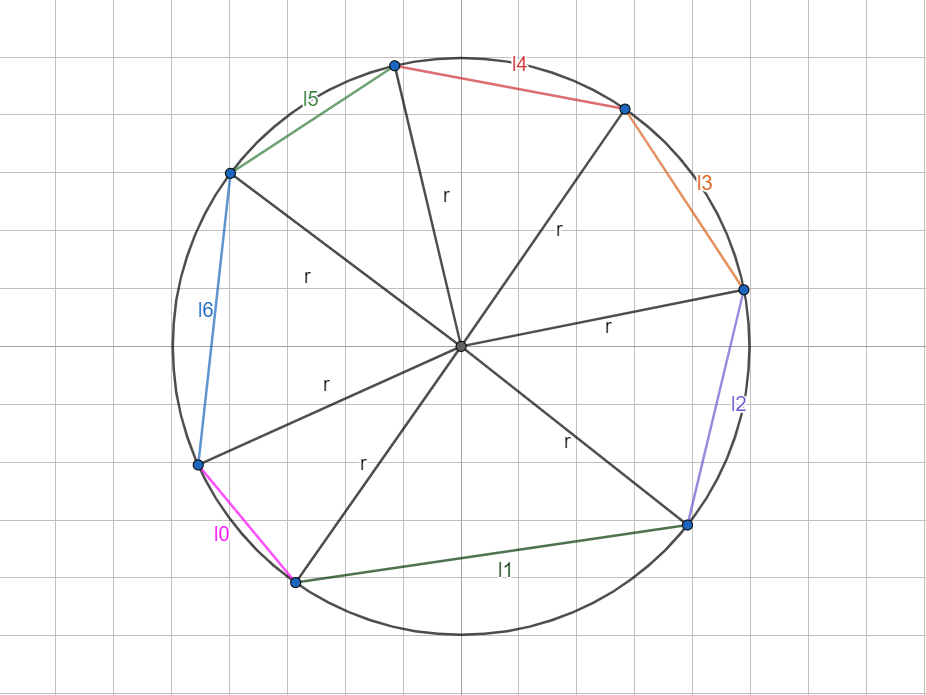

The area of the heptagon is the sum of all the areas of th eindividual equilateral triangles. Rearranging the triangles in space will not change the total area of the heptagon, which implies that for the neural network, it does not matter in what order the input lengths are passed.

Sorting the order of the inputs to the neural network can be altered, to improve performance. As the simple network that used just sorting proved to perform well, the existing `sort_ascending` function was used to sort the disambiguated data from the previous step. This will make th enural network "know" that inputs are always ordered from smallest to biggest, and the trainingn will be more efficient. 

In [ ]:
X_train_sort, X_test_sort = sort_ascending(X_train.to_numpy()), sort_ascending(X_test.to_numpy())
X_train_wide, X_test_wide = add_columns(X_train_sort)[input_cols], add_columns(X_test_sort)[input_cols]
X_train_wide

,0^2,01,1^2,12,2^2,23,3^2,34,4^2,45,5^2,56,6^2,60
0,0.004074,0.029244,0.209928,0.291255,0.404090,0.522836,0.676478,0.803345,0.954006,1.407307,2.075996,2.100313,2.124915,0.093041
1,0.015684,0.043600,0.121205,0.158707,0.207813,0.212733,0.217769,0.224722,0.231897,0.834142,3.000438,3.159337,3.326650,0.228418
2,0.014400,0.031444,0.068662,0.080888,0.095291,0.147244,0.227523,0.429163,0.809502,1.472304,2.677793,2.959252,3.270296,0.217008
3,0.015816,0.017157,0.018612,0.041647,0.093191,0.244583,0.641912,1.101603,1.890492,1.977462,2.068434,2.225158,2.393757,0.194573
4,0.002539,0.004472,0.007874,0.010882,0.015038,0.072311,0.347727,0.600676,1.037630,1.454222,2.038070,2.804515,3.859194,0.098994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.001452,0.013718,0.129609,0.183690,0.260337,0.424251,0.691369,0.968441,1.356552,1.378475,1.400752,1.991751,2.832100,0.064127
7996,0.020965,0.024740,0.029195,0.059906,0.122925,0.134653,0.147500,0.201365,0.274901,0.743726,2.012102,2.836821,3.999574,0.289571
7997,0.004790,0.005272,0.005803,0.031677,0.172908,0.177729,0.182684,0.505165,1.396907,1.808593,2.341608,2.781622,3.304319,0.125807
7998,0.003874,0.025006,0.161415,0.260035,0.418908,0.490861,0.575174,0.627310,0.684172,1.096766,1.758175,2.285094,2.969929,0.107260


In [ ]:
sort_models = train(X_train_wide, y_train, X_test_wide, y_test, name='sorted-disambig')
evaluate_net(sort_models, X_test_wide, y_test)
best_sort_network = get_best_network(sort_models, X_test_wide, y_test)
best_sort_network

Sorting the disambiguated data made another improvement to the loss: 

63/63 [==============================] - 0s 2ms/step - loss: 0.3251


The last approach yielded a significantly better results than the ealier models. The symmetry used in the final model positively contributed to the model's performance. Let us now retrain the model to check whether it can be optimized even further.

In [ ]:
retrained_models = retrain(model, X_train_wide, y_train, X_test_wide, y_test, name='again-retrained')
evaluate_net(retrained_models, X_test_wide, y_test)
best_retrained_network = get_best_network(retrained_models, X_test_wide, y_test)
model = retrained_models[best_retrained_network].get('model')

The model was retrained, improving the loss even further:

63/63 [==============================] - 0s 2ms/step - loss: 0.2025


The best model is now saved on google drive for later use.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# !ls /content/drive/MyDrive
# model.save('/content/drive/MyDrive/02025.h5')

# Influence of Hyperparameters on Neural Networks
Apart from developing a model that effectively predics areas from the given data, a study of the influence of several hyperparameters, including batch size, number of epochs and patience has been conducted. The results were presented using tensorboard screenshots and described in this section


a) Batch Size:


The batch size is the hyperparameter which defines the number of samlpes to work through before updating the internal model parameters. In other words, the batch size is the number of samples that are passed to the network at once. The larger the batch size, the quicker the model will carry out each epoch during training, since the machine may be able to process more than only one sample at a time. At the same time, the quality of the model may be decreased with a high batch size. Generally speaking, batch size must be tested and corrected in response to the specific model that is being used. Here in this section, the batch size of this specific model is tested and analyzed. \\

\




The best performing model, disambiguated model with 14 inputs, has been trained with three chosen batch sizes; 16, 32, 64, in order to examine how it influences the model performance. In order to do that, the `train_batches` function has been written which is a slight variation of the `train` function.

In [ ]:
def train_batches(X_train, y_train, X_test, y_test, ntrials=3, n_epochs = 100, patience=25, label='model_'):

    model_lst = []
    
    for i in range(ntrials):
        batch_sizes = [16, 32, 64]
        for k, batch_size in enumerate(batch_sizes):

            ## create an empty model
            model = create_model()
            ## instaciate EarlyStopping
            es_callback = [EarlyStopping(monitor = "val_loss", patience = patience, restore_best_weights=True)]

            ## Introduce tensorboard
            ## save into "logs/model_YYYYMMDD-HHMMSS" (you can obviously change this)
            my_dir = label + 'batch_size_'+ str(batch_size)
            logdir = os.path.join("logs", my_dir)
            tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

            keras_callbacks = [tb_callback, es_callback]

            ## training the model
            hist = model.fit(X_train, y_train,
                             epochs=n_epochs, verbose=0, callbacks=keras_callbacks, batch_size = batch_size,   
                             validation_data = (X_test, y_test))

            ## store the trained model and its history
            model_lst.append({'model':model, 'hist':hist})
    
    return model_lst

In [ ]:
batch_models = train_batches(X_train_dis, y_train, X_test_dis, y_test)
evaluate_net(batch_models, X_test_dis, y_test)
best_batch_network = get_best_network(batch_models, X_test_dis, y_test)
model = batch_models[best_batch_network].get('model')

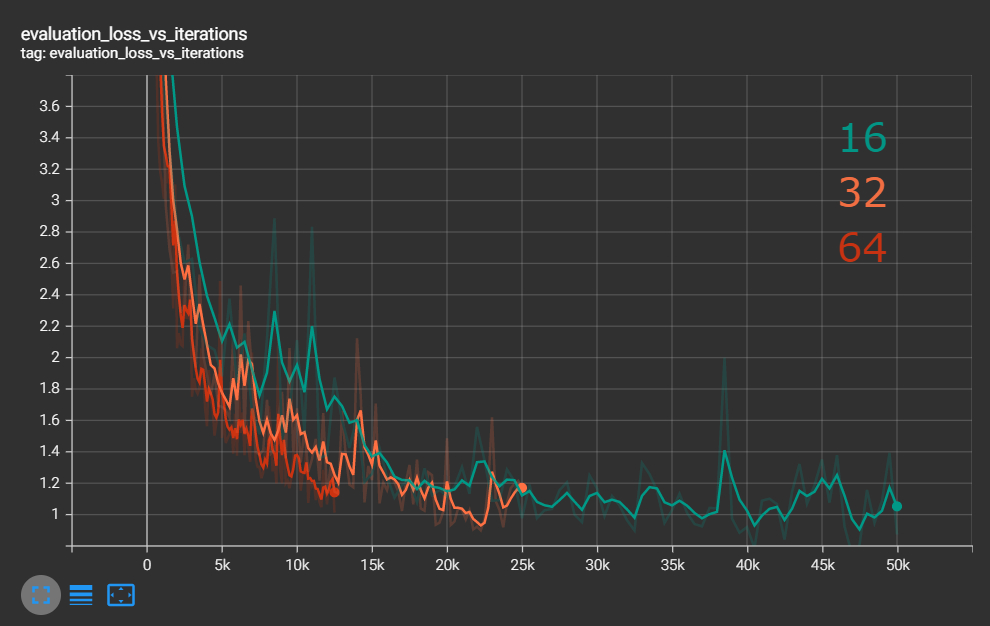

The plot above shows the loss as a function of number of iterations for three batch sizes of 16, 32 and 64 for the best performing model.

The batch size of 16 was the fastest to reach its final loss value followed by the batch size of 32 and the batch of 64 being last. The final loss values for each batch size are very close to each other. These final values also vary slightly with each initialisation of the model. Smaller batch sizes take more time to execute, but larger batch sizes resulted in a higher loss during our experiments. The optimal value for the batch size was chosen to be 16. \\


b) Number of epochs:


The epochs number is an important Hyperparameter in machine learning. An epoch means one complete pass of the training dataset through the model. This parameter specifies the number of complete passes of the total training data set through the learning algorithm. It is important to observe that with each epoch, the internal model's parameter are updated. For example, a one batch epoch is the so called gradient descent. The epoch's number is tipically an integer. Its value can reach thousands and the process is programmed to continue until the loss is minimized. Tipically, the number of epochs can be in the range of tens, hundreds or even thousands. This section covers the influence of epoch's number on the model's loss. 

\
To investigate the relevance of this parameter, all the others were kept constant and the chosen model was trained for a different number of epochs each time. 

In [ ]:
def train_epochs(X_train, y_train, X_test, y_test, ntrials=3, patience=25, label='model_'):

    model_lst = []
    
    for i in range(ntrials):
        epochs = [70, 100, 125]
        for k, epoch in enumerate(epochs):

            ## create an empty model
            model = create_model()
            ## instaciate EarlyStopping
            es_callback = [EarlyStopping(monitor = "val_loss", patience = patience, restore_best_weights=True)]

            ## Introduce tensorboard
            ## save into "logs/model_YYYYMMDD-HHMMSS" (you can obviously change this)
            my_dir = label + 'epoch_size_'+ str(epoch)
            logdir = os.path.join("logs", my_dir)
            tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

            keras_callbacks = [tb_callback, es_callback]

            ## training the model
            hist = model.fit(X_train, y_train,
                             epochs=epoch, verbose=0, callbacks=keras_callbacks,   
                             validation_data = (X_test, y_test))

            ## store the trained model and its history
            model_lst.append({'model':model, 'hist':hist})
    
    return model_lst

In [ ]:
epoch_models = train_epochs(X_train_dis, y_train, X_test_dis, y_test)
evaluate_net(epoch_models, X_test_dis, y_test)
best_epoch_network = get_best_network(epoch_models, X_test_dis, y_test)
model = epoch_models[best_epoch_network].get('model')

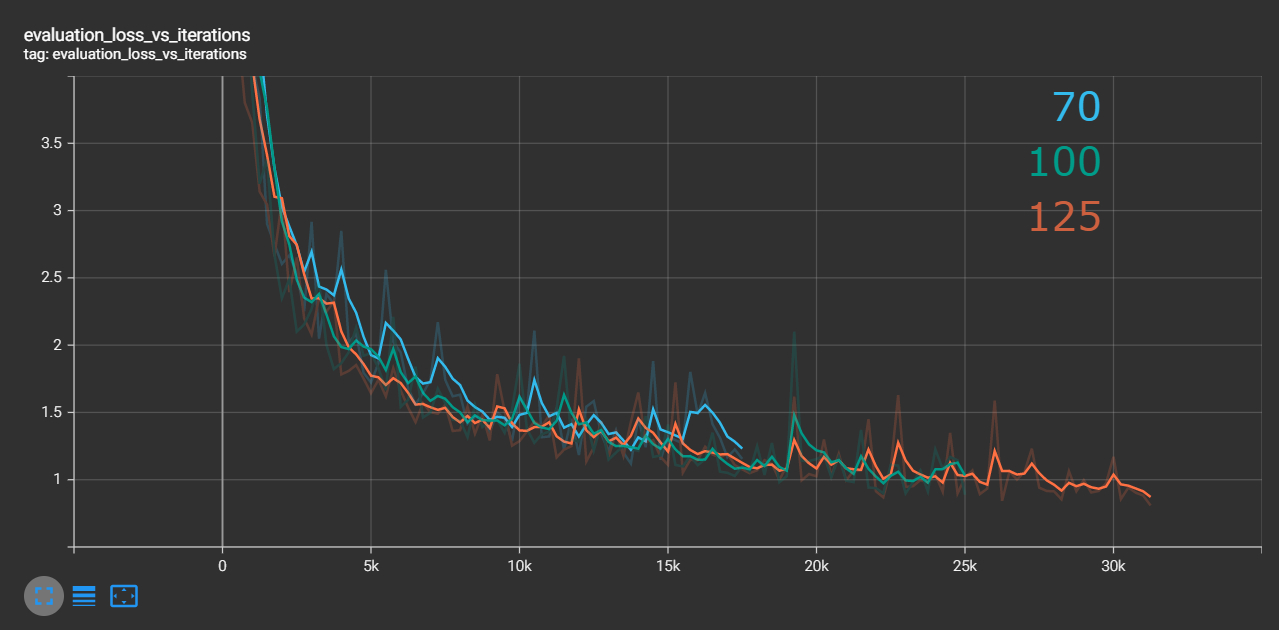

The plot above shows the loss as a function of number of iterations for three values of number of epochs for the best model.

The loss plots for all three values for number of epochs tend to fluctuate around the same curve whose slope becomes less steep with the number of iterations. This means that choosing a greater number of epochs only very slightly decreases the loss while increasing the computation time. The higher number of epochs was chosen as the computation time was still comfortably within reach.

c) Patience: 

In machine learning, patience is defined as the number of epochs without improvement, after which training will be early stopped. Early stopping is a feature that can be enabled to reduce computation times and to avoid useless results. A high value for patience implies that the model will wait longer before aborting a experiment. 

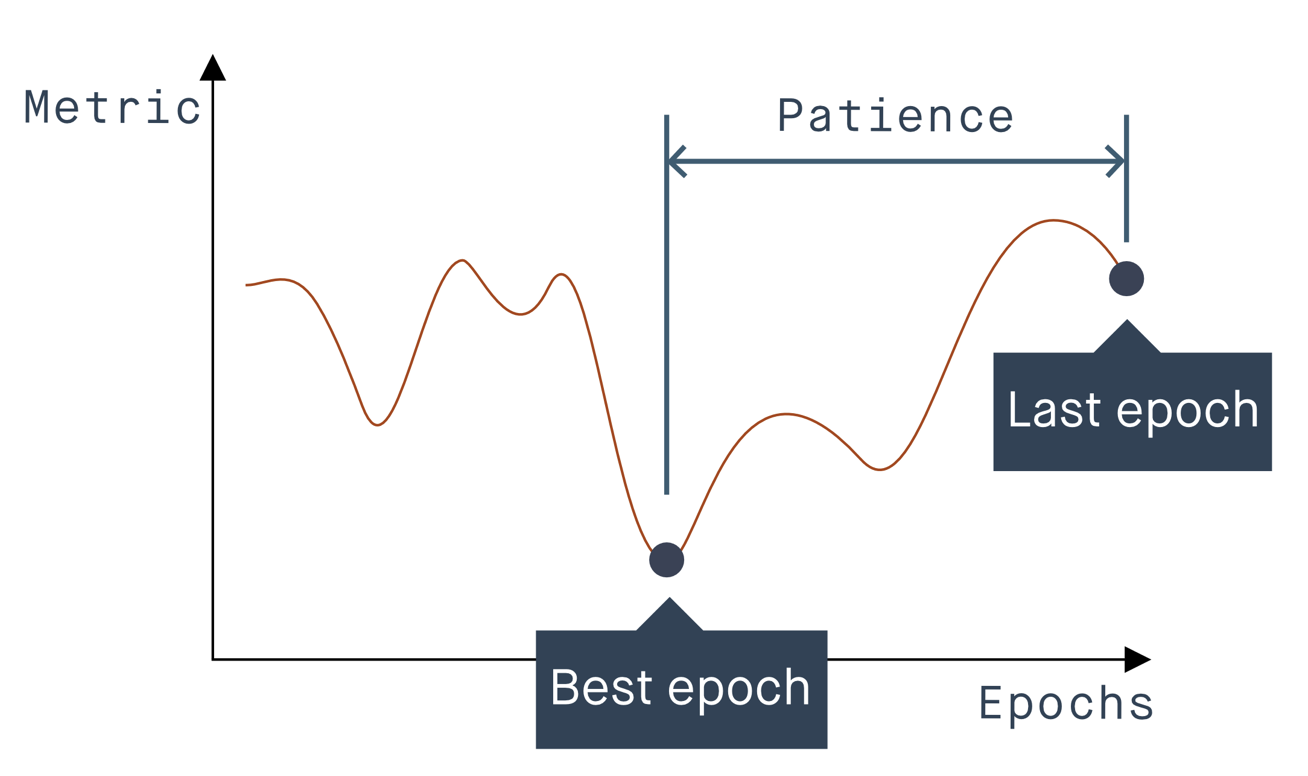

In [ ]:
def train_patience(X_train, y_train, X_test, y_test, ntrials=3, n_epochs=100, label='model_'):

    model_lst = []
    
    for i in range(ntrials):
        patiences = [15, 20, 25, 30]
        for k, patience in enumerate(patiences):

            ## create an empty model
            model = create_model()
            ## instaciate EarlyStopping
            es_callback = [EarlyStopping(monitor = "val_loss", patience = patience, restore_best_weights=True)]

            ## Introduce tensorboard
            ## save into "logs/model_YYYYMMDD-HHMMSS" (you can obviously change this)
            my_dir = label + 'patience_' +str(patience)
            logdir = os.path.join("logs", my_dir)
            tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

            keras_callbacks = [tb_callback, es_callback]

            ## training the model
            hist = model.fit(X_train, y_train,
                             epochs=n_epochs, verbose=0, callbacks=keras_callbacks,   
                             validation_data = (X_test, y_test))

            ## store the trained model and its history
            model_lst.append({'model':model, 'hist':hist})
    
    return model_lst

In [ ]:
patience_models = train_patience(X_train_dis, y_train, X_test_dis, y_test)
evaluate_net(patience_models, X_test_dis, y_test)
best_patience_network = get_best_network(patience_models, X_test_dis, y_test)
model = patience_models[best_patience_network].get('model')

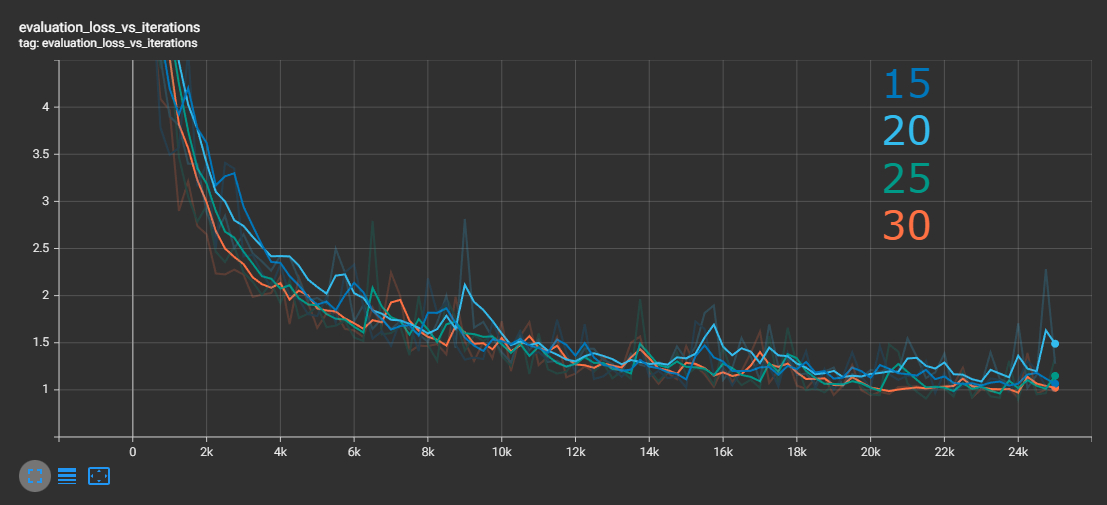

The loss as a function of number of iterations for four values of patience: 15, 20, 25, 30

The loss plots for each patience value tend to follow the same curve meaning that the patience has no significant impact on the performance of the model.

# Validating the Best Performing Model
Now that a series of neural networks has been build, trained and tested, the best neural networ kwas chosen to predict values for the Kaggle submission. The model that yielded the lowest MAPE ended to be the last network presented in this report. The best model has been saved in `02025.h5` file, so it be loaded and used for the avlidation data set. 

In [ ]:
model = tf.keras.models.load_model('02025.h5')

In [ ]:
# loading and formating submission data set
X_validation = pd.read_csv('x_test_id.csv')
X_validation.drop('id', axis=1, inplace=True)
X_validation = X_validation.reset_index().drop(columns=['index'])

# X_valid_cycle = mirror_cyclic(cyclic_sorting(X_validation.to_numpy()))
X_valid_sort = sort_ascending(X_validation.to_numpy())

X_work = add_columns(X_valid_sort)[input_cols]

df_valid = pd.DataFrame(X_work)
df_valid


,0^2,01,1^2,12,2^2,23,3^2,34,4^2,45,5^2,56,6^2,60
0,9.971594,29.077113,84.788700,134.014000,211.817757,218.768059,225.946420,310.426961,426.494468,699.125180,1146.031316,1320.372259,1521.234959,123.163053
1,44.072475,186.743686,791.269481,1397.952332,2469.791606,2997.874996,3638.871582,4095.285805,4608.946880,6789.113161,10000.561671,10708.799173,11467.193893,710.906194
2,0.563063,0.725595,0.935042,4.298137,19.757380,35.705292,64.526161,82.325666,105.035154,114.489972,124.795872,170.784208,233.719634,11.471657
3,14.076165,15.174942,16.359488,16.672357,16.991210,19.763938,22.989136,29.109128,36.858337,38.309233,39.817242,94.273472,223.207006,56.052642
4,8.167026,29.429311,106.046476,125.624378,148.816679,271.725590,496.145973,502.663458,509.266558,604.740342,718.112892,827.028500,952.463249,88.197463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,0.002897,0.017033,0.100153,0.124528,0.154834,0.286880,0.531538,0.694344,0.907017,1.133160,1.415687,3.135165,6.943099,0.141821
32996,1.883855,4.140961,9.102377,13.272012,19.351680,31.726098,52.013331,63.016660,76.347724,82.944735,90.111777,296.763129,977.323475,42.908454
32997,239.540828,283.678690,335.949408,394.129046,462.384219,1150.119948,2860.772145,2983.905327,3112.338401,5827.926881,10912.930202,18218.761262,30415.594694,2699.217802
32998,9.862678,23.631494,56.622300,209.026646,771.641888,884.865559,1014.702635,1139.644262,1279.970110,2201.434806,3786.272171,4049.501649,4331.031385,206.677450


In [ ]:
# predict areas using the model
results = model.predict(df_valid)
results = results.flatten()

In [ ]:
def format_submission(results, name_of_file):
    """Write data to csv for Kaggle submission."""
    df = pd.DataFrame({'Expected': results})
    df.index.name = 'Id'
    df.to_csv(name_of_file)
# Save results to csv 
format_submission(results, 'tutti_frutti_sub_15.csv')

# Conclusion and Reflection

All the models were sumarised in the figure below for a clear comparison.

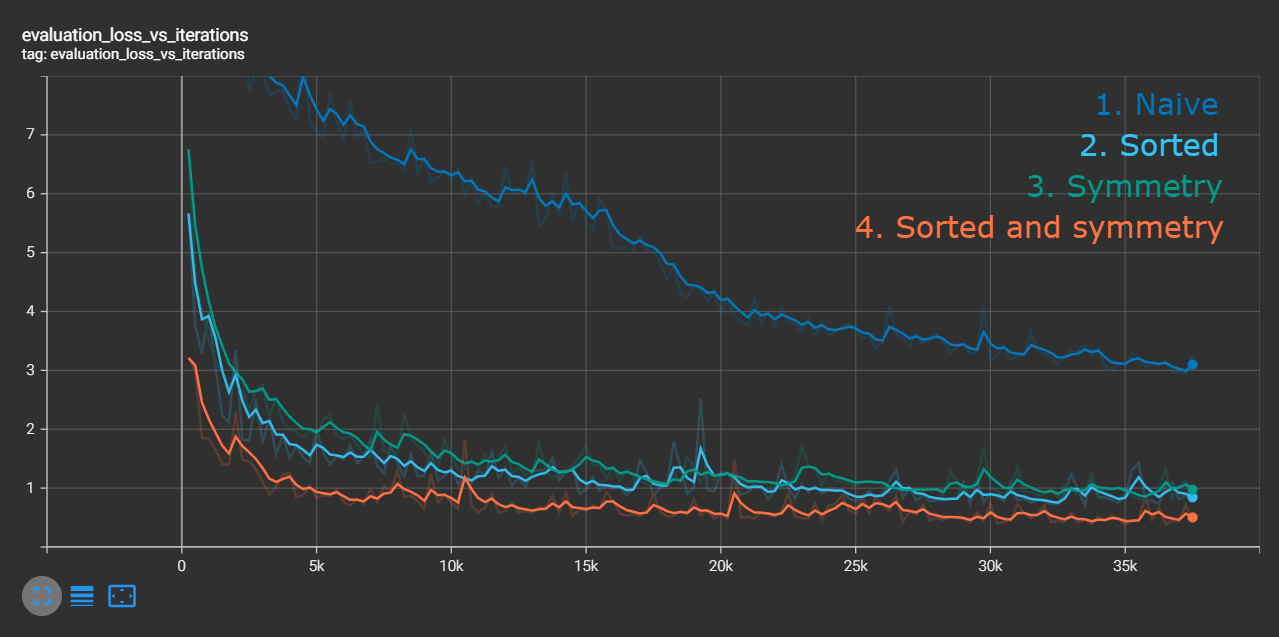

The plot above shows the loss as a function of number of iterations for each of the four models. As can be seen, implementing physics and geometrical properties into the neural network greatly imporves its performance. Making use of equivariance groups allows the network to be more accurate in predictions, when supervised learning is used. 

This assignment has shown that is extremely useful to fully understand the underlying problem to be solved, before thoughtlessly training a random neural network. Having good insights into the problem and iunderstanding dimensional homogeneity, equivariances and invariances has allowed us to finally design a successful network and format the data in such a way, that the predictive capacity of the network was very high. 

In [ ]:
%tensorboard --logdir logs